# 05 - swisstopo - Geothermische Karte der Schweiz 1:500000
### Author: Daniel Herrera-Russert
#### February 11, 2025

In [14]:
import requests
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.ops import unary_union

## 1. Obtaining the dataset

The **Geothermal Map of Switzerland 1:500'000** provides an overview of the heat flow density (measured in mW/m²) across Switzerland. The data represents geothermal energy produced in the subsurface and transferred to the Earth's surface. It is derived from measurements of temperature gradients (approximately 30 K/km) and the thermal conductivity of rocks (around 3 W/m·K). The dataset includes contour lines that indicate regional variations in geothermal heat flow, with the highest values found in northern Switzerland and lower values in alpine and Jura regions.

The dataset consists of vectorized geospatial data, primarily in the form of contour lines representing different levels of heat flow density. It is available in **GeoPackage (.gpkg) format**, which allows for efficient spatial data storage and analysis in GIS software. This dataset is particularly useful for geothermal energy research, subsurface heat distribution studies, and regional geological assessments.

The dataset is fetched from [Switzerland's open government data platform (opendata.swiss)](https://opendata.swiss/de/dataset/geothermische-karte-der-schweiz-1-500000), specifically from the **geo.admin.ch** repository. The data was accessed via a direct download link to the **GeoPackage format**, which contains structured geospatial layers. Once downloaded, the dataset can be loaded into GIS software or used for analysis with geospatial libraries like GeoPandas.

In [2]:
# Define the URL and output file name
gpkg_url = "https://data.geo.admin.ch/ch.swisstopo.geologie-geophysik-geothermie/geologie-geophysik-geothermie/geologie-geophysik-geothermie_2056.gpkg"
output_folder = "data/raw"
output_filename = "swisstopo_geothermie.gpkg"  # Rename the file

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Download the file
response = requests.get(gpkg_url, stream=True)
if response.status_code == 200:
    output_path = os.path.join(output_folder, output_filename)
    
    with open(output_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
    
    print(f"✅ GeoPackage downloaded and saved as {output_path}")
else:
    print("❌ Failed to download GeoPackage.")

✅ GeoPackage downloaded and saved as data/raw\swisstopo_geothermie.gpkg


---

### 1.1. Loading and visualizing the Dataset

In [10]:
# Load the file
swisstopo_geothermie_gdf =  gpd.read_file("data/raw/swisstopo_geothermie.gpkg")
swisstopo_geothermie_gdf.head()

C:\Users\leina\Documents\HSLU\24.2 Third Semester\W.MSCIDS_DE_DAE01.H2401 - Data Analytics for Energy Systems and IoT\.venv\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'swisstopo_geothermie.gpkg': 'isolines_heat_flux' (default), 'shape_highlight'. Specify layer parameter to avoid this warning.
  result = read_func(


,ID,CONTOUR,Line Type,Line_Nr,geometry
0,2,120,Solid,1,"MULTILINESTRING ((2652089.999 1282398.005, 265..."
1,3,110,Solid,2,"MULTILINESTRING ((2659638.426 1290858.73, 2661..."
2,4,100,Solid,3,"MULTILINESTRING ((2660844.794 1294657.378, 266..."
3,5,90,Solid,4,"MULTILINESTRING ((2635367.617 1300832.853, 263..."
4,6,80,Solid,5,"MULTILINESTRING ((2683101.923 1300781.34, 2683..."


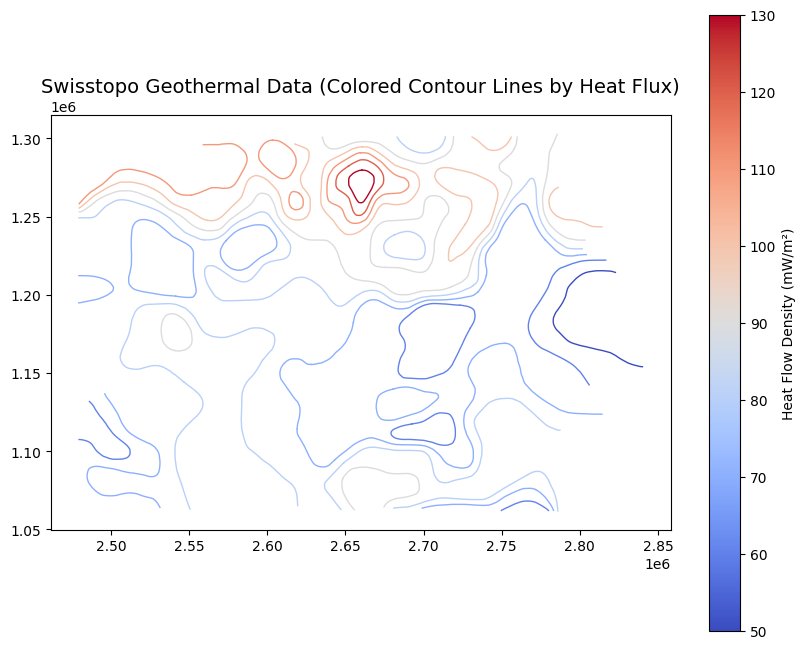

In [35]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from shapely.geometry import LineString, MultiLineString

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Get a colormap
cmap = plt.get_cmap("coolwarm")

# Normalize contour values for color mapping
norm = mcolors.Normalize(vmin=swisstopo_geothermie_gdf["CONTOUR"].min(), 
                         vmax=swisstopo_geothermie_gdf["CONTOUR"].max())

# Plot each contour line with color based on "CONTOUR" value
for _, row in swisstopo_geothermie_gdf.iterrows():
    color = cmap(norm(row["CONTOUR"]))  # Get color from colormap
    geom = row.geometry  # Get geometry

    # Handle LineString geometries
    if isinstance(geom, LineString):
        x, y = geom.xy
        ax.plot(x, y, color=color, linewidth=1)

    # Handle MultiLineString geometries correctly
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:  # Use .geoms to iterate over parts of MultiLineString
            x, y = line.xy
            ax.plot(x, y, color=color, linewidth=1)

# Add colorbar to show heat flux values
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Heat Flow Density (mW/m²)")

# Set equal aspect ratio
ax.set_aspect('equal')

# Customize plot
ax.set_title("Swisstopo Geothermal Data (Colored Contour Lines by Heat Flux)", fontsize=14)
plt.show()


---

### 1.2 Fetching the Shape Data for the entire Country

In [19]:
# Base API URL for canton boundaries
base_url = "https://api3.geo.admin.ch/rest/services/api/MapServer/ch.swisstopo.swissboundaries3d-kanton-flaeche.fill"

# List of all Swiss canton IDs (1 to 26)
canton_ids = list(range(1, 27))

# List to store each canton's GeoDataFrame (without saving files)
gdf_list = []

# Fetch each canton boundary and store in RAM
for canton_id in canton_ids:
    geojson_url = f"{base_url}/{canton_id}?geometryFormat=geojson&sr=4326"
    response = requests.get(geojson_url)

    if response.status_code == 200:
        # Load directly into GeoPandas from JSON response (no file saving)
        canton_gdf = gpd.read_file(response.text)
        gdf_list.append(canton_gdf)
        print(f"✅ Canton {canton_id} loaded into memory.")
    else:
        print(f"❌ Failed to fetch canton {canton_id}")

# Merge all canton geometries into a single Switzerland boundary
if gdf_list:
    merged_gdf = gpd.GeoDataFrame(
        geometry=[unary_union([gdf.geometry.iloc[0] for gdf in gdf_list])],
        crs=gdf_list[0].crs
    )

    # Save only the final merged boundary
    output_geojson = "data/raw/swissboundary_switzerland.geojson"
    merged_gdf.to_file(output_geojson, driver="GeoJSON")

    print(f"✅ Switzerland boundary saved as '{output_geojson}'")

✅ Canton 1 loaded into memory.
✅ Canton 2 loaded into memory.
✅ Canton 3 loaded into memory.
✅ Canton 4 loaded into memory.
✅ Canton 5 loaded into memory.
✅ Canton 6 loaded into memory.
✅ Canton 7 loaded into memory.
✅ Canton 8 loaded into memory.
✅ Canton 9 loaded into memory.
✅ Canton 10 loaded into memory.
✅ Canton 11 loaded into memory.
✅ Canton 12 loaded into memory.
✅ Canton 13 loaded into memory.
✅ Canton 14 loaded into memory.
✅ Canton 15 loaded into memory.
✅ Canton 16 loaded into memory.
✅ Canton 17 loaded into memory.
✅ Canton 18 loaded into memory.
✅ Canton 19 loaded into memory.
✅ Canton 20 loaded into memory.
✅ Canton 21 loaded into memory.
✅ Canton 22 loaded into memory.
✅ Canton 23 loaded into memory.
✅ Canton 24 loaded into memory.
✅ Canton 25 loaded into memory.
✅ Canton 26 loaded into memory.
✅ Switzerland boundary saved as 'data/raw/swissboundary_switzerland.geojson'


In [21]:
# Load Switzerland boundary
swiss_boundary_gdf = gpd.read_file("data/raw/swissboundary_switzerland.geojson")

# Convert Switzerland boundary to Swiss LV95 (EPSG:2056)
swiss_boundary_gdf = swiss_boundary_gdf.to_crs(epsg=2056)

# Print the new coordinate system
print("✅ Transformed CRS:", swiss_boundary_gdf.crs)

✅ Transformed CRS: EPSG:2056


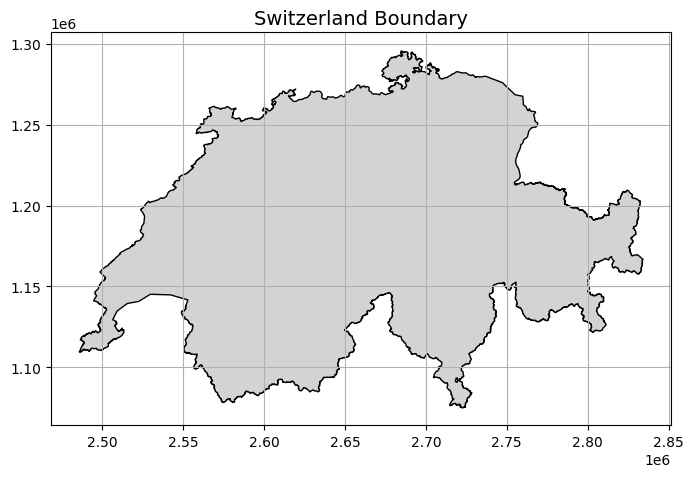

In [23]:
# Quick plot
fig, ax = plt.subplots(figsize=(8, 8))
swiss_boundary_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=1)
ax.set_title("Switzerland Boundary", fontsize=14)

plt.grid(True)
plt.show()

In [ ]:
import geopandas as gpd
from shapely.ops import unary_union, polygonize

# Merge all contour lines
merged_lines = unary_union(swisstopo_geothermie_gdf.geometry)

# Convert to polygons
polygons = list(polygonize(merged_lines))

# Create a new GeoDataFrame with polygons
polygon_gdf = gpd.GeoDataFrame(geometry=polygons, crs=swisstopo_geothermie_gdf.crs)

# Plot polygons
polygon_gdf.plot(cmap="coolwarm", edgecolor="black", alpha=0.6)
plt.title("Geothermal Contours as Polygons")
plt.show()

---

## 2.2 Transforming the Dataset into enclosed Polygons

C:\Users\leina\AppData\Local\Temp\ipykernel_27248\1663091178.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  swiss_shape = swiss_boundary_gdf.unary_union  # Create a single national boundary
C:\Users\leina\Documents\HSLU\24.2 Third Semester\W.MSCIDS_DE_DAE01.H2401 - Data Analytics for Energy Systems and IoT\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


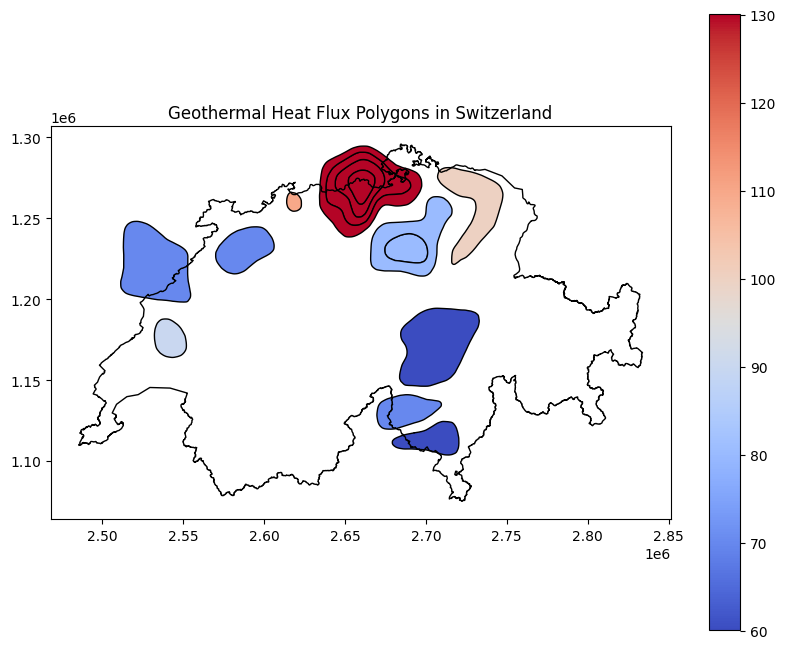

In [36]:
import geopandas as gpd
from shapely.ops import unary_union, polygonize
import matplotlib.pyplot as plt

# Step 1: Merge all contour lines into a single geometry collection
merged_lines = unary_union(swisstopo_geothermie_gdf.geometry)

# Step 2: Convert contour lines into enclosed polygons
polygons = list(polygonize(merged_lines))

# Step 3: Create a GeoDataFrame for the new polygons
polygon_gdf = gpd.GeoDataFrame(geometry=polygons, crs=swisstopo_geothermie_gdf.crs)

# Step 4: Clip the polygons to Switzerland’s boundary
swiss_shape = swiss_boundary_gdf.unary_union  # Create a single national boundary
clipped_polygons = polygon_gdf[polygon_gdf.geometry.intersects(swiss_shape)]

# Step 5: Assign heat flux values to polygons (using the nearest contour line)
def assign_heat_flux(polygon, contour_gdf):
    nearest_contour = contour_gdf.distance(polygon.centroid).idxmin()
    return contour_gdf.loc[nearest_contour, "CONTOUR"]

# Apply heat flux assignment
clipped_polygons["HEAT_FLUX"] = clipped_polygons.geometry.apply(lambda poly: assign_heat_flux(poly, swisstopo_geothermie_gdf))

# Save the final enclosed polygons dataset
clipped_polygons.to_file("data/raw/geothermal_polygons.geojson", driver="GeoJSON")

# Plot the final polygons with color by heat flux value
fig, ax = plt.subplots(figsize=(10, 8))
clipped_polygons.plot(column="HEAT_FLUX", ax=ax, cmap="coolwarm", edgecolor="black", legend=True)
swiss_boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)  # Overlay Swiss boundary
ax.set_title("Geothermal Heat Flux Polygons in Switzerland")
plt.show()
